In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)

#Simulate Merchants & Orders
n_merchants = 40
orders_per_merchant = 250

rows = []

for merchant_id in range(n_merchants):

    base_bias = np.random.normal(2.5, 0.8)

    for _ in range(orders_per_merchant):

        orders_last_10min = np.random.randint(1, 25)

        # True prep increases with rush
        true_prep = np.random.normal(20, 3) + (orders_last_10min * 0.2)

        rider_travel = np.random.normal(10, 2)

        acceptance_delay = np.random.normal(1, 0.3)

        merchant_FOR = true_prep + base_bias

        rider_arrival = true_prep + rider_travel

        rows.append([
            merchant_id,
            true_prep,
            merchant_FOR,
            rider_arrival,
            orders_last_10min,
            acceptance_delay
        ])

data = pd.DataFrame(rows, columns=[
    "merchant_id",
    "true_prep",
    "merchant_FOR",
    "rider_arrival",
    "orders_last_10min",
    "acceptance_delay"
])

In [ ]:

#Merchant Bias Correction
data["arrival_minus_FOR"] = data["rider_arrival"] - data["merchant_FOR"]

merchant_bias_table = (
    data.groupby("merchant_id")["arrival_minus_FOR"]
    .mean()
    .reset_index()
    .rename(columns={"arrival_minus_FOR": "MBI"})
)

data = data.merge(merchant_bias_table, on="merchant_id")

data["corrected_FOR"] = data["merchant_FOR"] - data["MBI"]

#Kitchen Stress Index
data["orders_norm"] = data["orders_last_10min"] / data["orders_last_10min"].max()
data["acceptance_norm"] = data["acceptance_delay"] / data["acceptance_delay"].max()

data["LKSI"] = 0.7 * data["orders_norm"] + 0.3 * data["acceptance_norm"]

data["adjusted_KPT"] = data["corrected_FOR"] * (1 + data["LKSI"])

In [ ]:
#Evaluation Metrics
data["error_before"] = abs(data["merchant_FOR"] - data["true_prep"])
data["error_after"] = abs(data["adjusted_KPT"] - data["true_prep"])

MAE_before = data["error_before"].mean()
MAE_after = data["error_after"].mean()

P50_before = np.percentile(data["error_before"], 50)
P50_after = np.percentile(data["error_after"], 50)

P90_before = np.percentile(data["error_before"], 90)
P90_after = np.percentile(data["error_after"], 90)

print("MAE Before:", round(MAE_before,2))
print("MAE After:", round(MAE_after,2))
print("P50 Error Before:", round(P50_before,2))
print("P50 Error After:", round(P50_after,2))
print("P90 Error Before:", round(P90_before,2))
print("P90 Error After:", round(P90_after,2))

MAE Before: 2.27
MAE After: 4.85
P50 Error Before: 2.17
P50 Error After: 3.78
P90 Error Before: 3.19
P90 Error After: 10.67


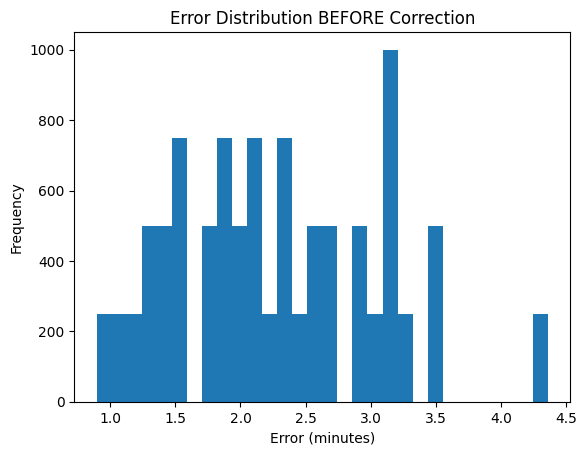

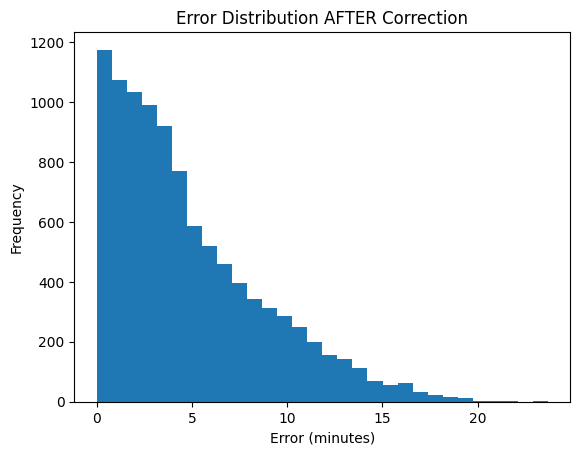

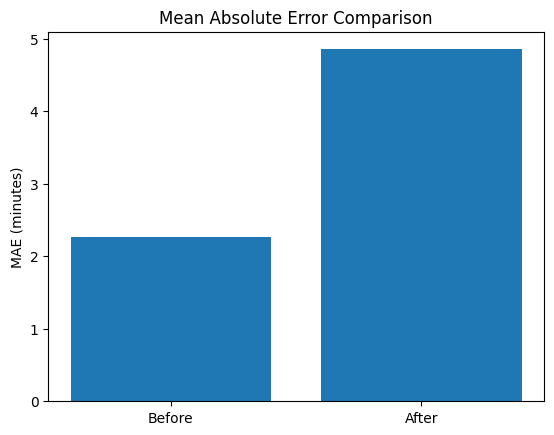

In [ ]:
#Visualization
plt.figure()
plt.hist(data["error_before"], bins=30)
plt.title("Error Distribution BEFORE Correction")
plt.xlabel("Error (minutes)")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.hist(data["error_after"], bins=30)
plt.title("Error Distribution AFTER Correction")
plt.xlabel("Error (minutes)")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.bar(["Before", "After"], [MAE_before, MAE_after])
plt.title("Mean Absolute Error Comparison")
plt.ylabel("MAE (minutes)")
plt.show()